In [2]:
!pip install trimesh

     |████████████████████████████████| 634kB 6.5MB/s 


In [3]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [9]:
import trimesh
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import torch

In [5]:
tool_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0018_rig000.obj',process=False)
fabric_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/0018_000.obj',process=False)

In [6]:
scene = trimesh.Scene([tool_mesh, fabric_mesh])
scene.show(viewer='notebook')

In [10]:
torch_fabric_v = torch.tensor(fabric_mesh.vertices)
torch_fabric_f = torch.tensor(fabric_mesh.faces)

torch_tool_v = torch.tensor(tool_mesh.vertices)
torch_tool_f = torch.tensor(tool_mesh.faces)

(array([114.,  31.,  19.,  11.,  19.,  36.,  29.,  32.,  14.,   7.]),
 array([1.74623732e-04, 1.27081378e-01, 2.53988132e-01, 3.80894885e-01,
        5.07801639e-01, 6.34708393e-01, 7.61615147e-01, 8.88521901e-01,
        1.01542865e+00, 1.14233541e+00, 1.26924216e+00]),
 <a list of 10 Patch objects>)

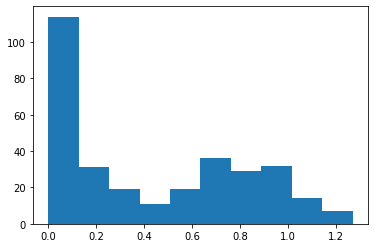

In [68]:
weights = (torch_tool_v - torch_fabric_v)[:,2]
thresh = 0.1
weights = torch.exp(weights/thresh)
plt.hist(weights)

In [69]:
xy = torch_fabric_v[:,0:2]
contact = xy[weights>0.5]
noncontact = xy[weights<0.5]

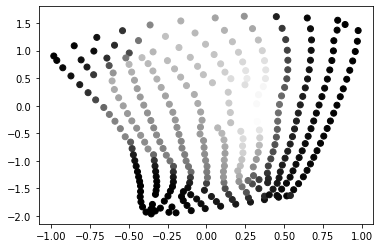

In [70]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(), c=weights.numpy(), cmap='gray')

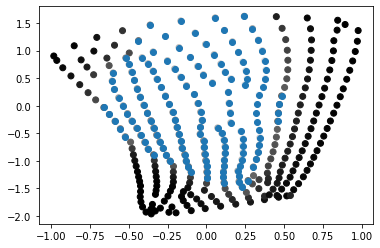

In [71]:
plt.scatter(xy[:,0].numpy(), xy[:,1].numpy(), c=weights.numpy(), cmap='gray')
plt.scatter(contact[:,0].numpy(), contact[:,1].numpy())

In [72]:
A = xy
C = A.mean(dim=(-2,), keepdim=True)
U,S,V = torch.svd(A - C)
P2 = torch.matmul(A, V[:, :2])
P1 = torch.matmul(A, V[:, :1])

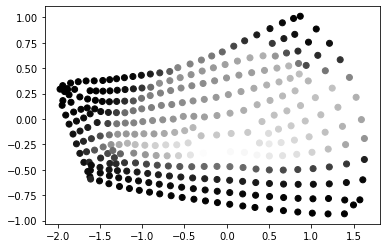

In [73]:
plt.scatter(P2[:,0], P2[:,1], c=weights.numpy(), cmap='gray')

In [89]:
def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

#need to incorporate weights
m,std,skewness,kurtoses = get_moments(P2[:,0]*weights.numpy())

#bimodality test, bigger is more likely to be bimodal
(skewness**2 + 1)/kurtoses

tensor(1.3659, dtype=torch.float64)

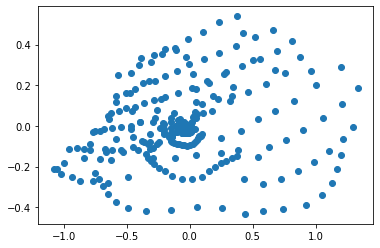

In [90]:
plt.scatter(P2[:,0]*weights.numpy(), P2[:,1]*weights.numpy(), cmap='gray')

In [165]:
def get_moments(d):
    mean = torch.mean(d,0,keepdim=True)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0),0,keepdim=True)
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0),0,keepdim=True)
    kurtoses = torch.mean(torch.pow(zscores, 4.0),0,keepdim=True) - 3.0 #this makes it between 0-1 and we are supposed to use 0.555 as the threshold, but really we want a scale that gets much worse, so mahybe leave it as excess kurtosis?
    return torch.cat((mean,std,skews,kurtoses)).transpose(1,0)

def pca(xy):
    A = xy
    #center
    C = A.mean(dim=(-2,), keepdim=True)
    U,S,V = torch.svd(A - C)
    #project onto principal components
    P2 = torch.matmul(A, V[:, :2])
    P1 = torch.matmul(A, V[:, :1])
    return P2

def test(moments):
    #BC multimodality test (although using excess kurtosis, not corrected kurtosis)
    skewness = moments[:,2]
    kurtoses = moments[:,3]
    return (skewness**2 + 1)/kurtoses

weights = (torch_tool_v - torch_fabric_v)[:,2]
thresh = 0.1
weights = torch.exp(weights/thresh)

xy = torch_fabric_v[:,0:2]

p = pca(xy)
m = get_moments(p*(weights).unsqueeze(1).repeat(1,2))
loss = torch.sum(torch.abs(test(m))) #higher is worse
loss

tensor(3.0942, dtype=torch.float64)